In [8]:
from typing import Annotated

from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from IPython.display import Image, display

In [9]:
messages = [
    AIMessage(content=f"So you said you were researching ocean mammals?", name="Model"),
    HumanMessage(content=f"Yes, that's right.", name="Lance"),
    AIMessage(content=f"Great, what would you like to learn about.", name="Model"),
    HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance")
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [10]:
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [11]:
result

AIMessage(content='The best places to see orcas in the U.S. are typically in the coastal waters of the Pacific Northwest, where resident populations are known to frequent. Here are some top locations:\n\n1. **San Juan Islands, Washington**: The San Juan Islands are considered one of the best spots to observe orcas in their natural habitat. Between May and September, you can see Southern Resident Killer Whales, as well as transient orcas, near Lime Kiln Point State Park (also known as "Whale Watch Park").\n\n2. **Puget Sound, Washington**: Orcas can often be spotted in this body of water near Seattle, particularly during the spring and summer months.\n\n3. **Bellingham, Washington**: Whale-watching tours departing from Bellingham provide excellent opportunities to spot orcas in the Salish Sea.\n\n4. **Westport, Washington (off the Washington coast)**: Orcas occasionally venture into offshore waters along Washington\'s coast.\n\n5. **Monterey Bay, California**: Orcas in this area are typ

In [12]:
result.response_metadata

{'token_usage': {'completion_tokens': 252,
  'prompt_tokens': 67,
  'total_tokens': 319,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-11-20',
 'system_fingerprint': 'fp_ee1d74bde0',
 'id': 'chatcmpl-Bqy9v03cyQts8gSNQznmzekyP6Fqk',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

In [13]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])
llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b3IMA2YsnugaAbSPSSmPmbXZ', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 62, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BqyA5vuuHO9MpntqgZvPhBTosTSiC', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4147c80c-0d65-4dc8-bb04-958c636a7607-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_b3IMA2YsnugaAbSPSSmPmbXZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 18, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0

In [14]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='60d32315-fb5e-4226-8c76-050c461da256'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='3f28b2be-7014-4ba8-b807-797128b9db9f'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='b22c4ab6-b435-4171-b520-187abd49df99')]

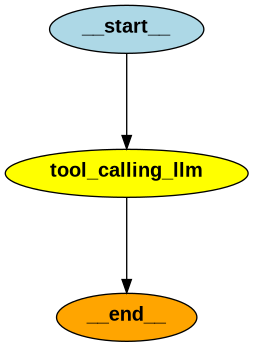

In [15]:
class MessagesState(MessagesState):
    pass


def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_png()))

In [16]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_f9BwkpuNbehHndMbOvFOk7Qx)
 Call ID: call_f9BwkpuNbehHndMbOvFOk7Qx
  Args:
    a: 2
    b: 3
